In [34]:
import os, json, math, random, glob, re
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---- 루트/스플릿 디렉토리 정의 ----
BASE_DIR = Path("/home/jinjinjara1022/AutonomousDriving/datasets/tusimple")
ALT_DIR  = BASE_DIR / "TUSimple"          # 실제 루트
TRAIN_DIR = ALT_DIR / "train_set"         # ★ raw_file 은 여기 기준 (clips/...)
TEST_DIR  = ALT_DIR / "test_set"

# 1) 학습용 라벨(딱 3개만)
train_label_files = [
    TRAIN_DIR / "label_data_0313.json",
    TRAIN_DIR / "label_data_0531.json",
    TRAIN_DIR / "label_data_0601.json",
]
train_label_files = [p for p in train_label_files if p.exists()]
assert len(train_label_files) > 0, f"train 라벨 파일을 찾지 못했습니다: {TRAIN_DIR}"

print("학습에 사용하는 라벨:", [p.name for p in train_label_files])

# 2) (선택) 검증/평가용 라벨: test_set 기준으로만 확인
eval_label_candidates = [
    BASE_DIR / "test_label_new.json",
]
eval_label_files = [p for p in eval_label_candidates if p.exists()]
print("평가에 사용할 수 있는 라벨(선택):", [p.name for p in eval_label_files])

# 3) 이미지 경로 해석 (split에 따라 기준 폴더 다르게)
def resolve_img_path(raw_file: str, split: str = "train"):
    base = TRAIN_DIR if split == "train" else TEST_DIR
    p = base / raw_file  # raw_file 예: "clips/0313-1/60/20.jpg"
    return p if p.exists() else None

# 4) 학습 샘플 수집 (존재하는 파일만)
train_samples = []
for lf in train_label_files:
    with open(lf, "r") as f:
        for line in f:
            try:
                j = json.loads(line)
            except json.JSONDecodeError:
                continue
            rf = j.get("raw_file")
            if not rf:
                continue
            if resolve_img_path(rf, split="train") is not None:
                train_samples.append(j)

print("학습 샘플 수:", len(train_samples))

# (옵션) 몇 개만 빠르게 검증
for k in range(min(3, len(train_samples))):
    rf = train_samples[k]["raw_file"]
    p = resolve_img_path(rf, "train")
    print(f"[sample{k}] {rf} -> {p} exists: {p.exists() if p else None}")

# 재현성
random.seed(0); np.random.seed(0); torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


학습에 사용하는 라벨: ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
평가에 사용할 수 있는 라벨(선택): ['test_label_new.json']
학습 샘플 수: 3626
[sample0] clips/0313-1/6040/20.jpg -> /home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/train_set/clips/0313-1/6040/20.jpg exists: True
[sample1] clips/0313-1/5320/20.jpg -> /home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/train_set/clips/0313-1/5320/20.jpg exists: True
[sample2] clips/0313-1/23700/20.jpg -> /home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/train_set/clips/0313-1/23700/20.jpg exists: True
device: cuda


In [35]:
# 마스크 그리기 함수
def draw_lane_mask(h, w, lanes, h_samples, thickness=6):
    mask = np.zeros((h, w), dtype=np.uint8)
    for lane in lanes:
        pts = []
        for x, y in zip(lane, h_samples):
            if x > 0 and 0 <= y < h and 0 <= x < w:
                pts.append((int(x), int(y)))
        # 연속 구간을 라인으로 연결
        for i in range(len(pts)-1):
            cv2.line(mask, pts[i], pts[i+1], 255, thickness=thickness)
    return mask  # 0/255

In [36]:
class TuSimpleLaneDataset(Dataset):
    def __init__(self, samples, img_size=(360, 640), augment=False):
        self.samples = samples
        self.img_h, self.img_w = img_size
        self.augment = augment
        # transforms
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img_path = resolve_img_path(s["raw_file"])
        img = cv2.imread(str(img_path))
        if img is None:
            raise FileNotFoundError(img_path)
        h0, w0 = img.shape[:2]

        # 원본 크기로 마스크 생성 후 리사이즈
        mask = draw_lane_mask(h0, w0, s["lanes"], s["h_samples"], thickness=6)

        # 리사이즈 (H,W) = (360,640)
        img = cv2.resize(img, (self.img_w, self.img_h), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.img_w, self.img_h), interpolation=cv2.INTER_NEAREST)

        # BGR->RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augment:
            # 가벼운 수평 이동/밝기 변화 등 (필요시 확장)
            pass

        img_t = self.to_tensor(img)            # [3,H,W], 0~1
        img_t = self.normalize(img_t)
        mask_t = torch.from_numpy((mask>0).astype(np.float32)).unsqueeze(0)  # [1,H,W], 0/1
        return img_t, mask_t, str(img_path)

In [37]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNetTiny(nn.Module):
    def __init__(self, in_ch=3, n_classes=1, base=32):
        super().__init__()
        self.d1 = DoubleConv(in_ch, base)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(base, base*2)
        self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(base*2, base*4)
        self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(base*4, base*8)
        self.p4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*8, base*16)

        self.u4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.up4 = DoubleConv(base*16, base*8)
        self.u3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.up3 = DoubleConv(base*8, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.up2 = DoubleConv(base*4, base*2)
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.up1 = DoubleConv(base*2, base)

        self.outc = nn.Conv2d(base, n_classes, 1)

    def forward(self, x):
        d1 = self.d1(x); p1 = self.p1(d1)
        d2 = self.d2(p1); p2 = self.p2(d2)
        d3 = self.d3(p2); p3 = self.p3(d3)
        d4 = self.d4(p3); p4 = self.p4(d4)
        bn = self.bottleneck(p4)
        x = self.u4(bn); x = torch.cat([x, d4], dim=1); x = self.up4(x)
        x = self.u3(x);  x = torch.cat([x, d3], dim=1); x = self.up3(x)
        x = self.u2(x);  x = torch.cat([x, d2], dim=1); x = self.up2(x)
        x = self.u1(x);  x = torch.cat([x, d1], dim=1); x = self.up1(x)
        return self.outc(x)

In [38]:
# ---- 클립 단위 분할 ----
from collections import defaultdict
import random

samples = train_samples  # train_set 라벨 3개로 만든 리스트

# 1) clip_id 추출
def clip_id_of(raw_file: str):
    parts = raw_file.strip("/").split("/")
    if len(parts) >= 3 and parts[0] == "clips":
        return "/".join(parts[:3])  # clips/0313-1/6040
    return raw_file

# 2) clip -> frame 인덱스 매핑
clip_to_indices = defaultdict(list)
for i, j in enumerate(samples):
    rf = j.get("raw_file", "")
    cid = clip_id_of(rf)
    clip_to_indices[cid].append(i)

clip_ids = list(clip_to_indices.keys())
random.shuffle(clip_ids)

# 3) train/val 클립 분리
train_ratio = 0.9
cut = int(len(clip_ids) * train_ratio)
train_clips = clip_ids[:cut]
val_clips   = clip_ids[cut:]

train_idx = [i for cid in train_clips for i in clip_to_indices[cid]]
valid_idx = [i for cid in val_clips  for i in clip_to_indices[cid]]

print(f"[debug] total samples: {len(samples)}")
print(f"[debug] clips: {len(clip_ids)}, train_clips: {len(train_clips)}, val_clips: {len(val_clips)}")
print(f"[debug] frame idx pre-cap: train={len(train_idx)} val={len(valid_idx)}")

# 4) 0개 방지: val이 비었을 경우 하나 떼어주기
if len(val_clips) == 0 and len(train_clips) > 1:
    val_clips.append(train_clips.pop())
    train_idx = [i for cid in train_clips for i in clip_to_indices[cid]]
    valid_idx = [i for cid in val_clips  for i in clip_to_indices[cid]]

# 5) 데모 상한 적용
max_train = min(2782, len(train_idx))
max_valid = min(200,  len(valid_idx))
random.shuffle(train_idx); random.shuffle(valid_idx)
train_idx = train_idx[:max_train]
valid_idx = valid_idx[:max_valid]

print(f"[debug] frame idx post-cap: train={len(train_idx)} val={len(valid_idx)}")

# 6) 최종 안전장치: 여전히 한쪽이 0이면 프레임 기반 분할로 폴백
if len(train_idx) == 0 or len(valid_idx) == 0:
    print("[warn] clip split 실패 → 프레임 기반 90:10 임시 분할")
    all_idx = list(range(len(samples)))
    random.shuffle(all_idx)
    cut = int(len(all_idx) * 0.9)
    train_idx, valid_idx = all_idx[:cut], all_idx[cut:]
    # 데모 상한 재적용
    train_idx = train_idx[:max(1, min(2782, len(train_idx)))]
    valid_idx = valid_idx[:max(1, min(200,  len(valid_idx)))]
    print(f"[debug] fallback split: train={len(train_idx)} val={len(valid_idx)}")

# 7) 실제 파일 존재 여부 체크
def has_img(j):
    p = resolve_img_path(j.get("raw_file", ""), split="train")
    return (p is not None) and p.exists()

train_samples_sel = [samples[i] for i in train_idx if has_img(samples[i])]
valid_samples_sel = [samples[i] for i in valid_idx if has_img(samples[i])]

print(f"[debug] existing files: train={len(train_samples_sel)} val={len(valid_samples_sel)}")
assert len(train_samples_sel) > 0, "train 샘플이 0개입니다."
assert len(valid_samples_sel) > 0, "valid 샘플이 0개입니다."

# 8) Dataset & DataLoader
train_ds = TuSimpleLaneDataset(train_samples_sel, img_size=(352,640), augment=True)
valid_ds = TuSimpleLaneDataset(valid_samples_sel, img_size=(352,640), augment=False)

print(f"[debug] dataset lens: train={len(train_ds)} val={len(valid_ds)}")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_ds, batch_size=8, shuffle=False,
                          num_workers=2, pin_memory=True)


[debug] total samples: 3626
[debug] clips: 3626, train_clips: 3263, val_clips: 363
[debug] frame idx pre-cap: train=3263 val=363
[debug] frame idx post-cap: train=2782 val=200
[debug] existing files: train=2782 val=200
[debug] dataset lens: train=2782 val=200


In [39]:
def iou_score_logits(logits, target, eps=1e-6):
    # logits -> prob -> binarize
    probs = torch.sigmoid(logits)
    pred_bin = (probs > 0.5).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = (pred_bin + target - pred_bin*target).sum(dim=(1,2,3)) + eps
    return inter, union  # 배치별 인터섹션/유니온 반환

model = UNetTiny().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

use_amp = (device == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

epochs = 10
best = {"iou": -1.0, "loss": float("inf")}
ckpt_path = "unet_tiny_tusimple.pth"

for epoch in range(1, epochs+1):
    model.train()
    tr_loss_sum, inter_sum, union_sum, seen = 0.0, 0.0, 0.0, 0

    for step, (imgs, masks, _) in enumerate(train_loader, 1):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()

        # shape 정합성(채널 수) 강제: (B,1,H,W)로 맞추기
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)
        elif masks.size(1) != 1:
            masks = masks[:, :1, ...]  # 필요시 첫 채널만

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(imgs)
            if logits.size() != masks.size():
                # 출력 크기가 다르면 보간해서 맞춤
                logits = torch.nn.functional.interpolate(
                    logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
                )
            loss = loss_fn(logits, masks)

        # backward
        scaler.scale(loss).backward()
        # gradient clipping
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(opt)
        scaler.update()

        # 통계
        tr_loss_sum += loss.item() * imgs.size(0)
        inter_b, union_b = iou_score_logits(logits.detach(), masks)
        inter_sum += inter_b.sum().item()
        union_sum += union_b.sum().item()
        seen += imgs.size(0)

    tr_loss = tr_loss_sum / max(1, seen)
    tr_iou = (inter_sum / (union_sum if union_sum > 0 else 1.0))

    # ---- validation ----
    model.eval()
    va_loss_sum, v_inter_sum, v_union_sum, v_seen = 0.0, 0.0, 0.0, 0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
        for imgs, masks, _ in valid_loader:
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).float()
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            elif masks.size(1) != 1:
                masks = masks[:, :1, ...]
            logits = model(imgs)
            if logits.size() != masks.size():
                logits = torch.nn.functional.interpolate(
                    logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
                )
            loss = loss_fn(logits, masks)
            va_loss_sum += loss.item() * imgs.size(0)

            inter_b, union_b = iou_score_logits(logits, masks)
            v_inter_sum += inter_b.sum().item()
            v_union_sum += union_b.sum().item()
            v_seen += imgs.size(0)

    va_loss = va_loss_sum / max(1, v_seen)
    va_iou = (v_inter_sum / (v_union_sum if v_union_sum > 0 else 1.0))

    print(f"[{epoch}/{epochs}] "
          f"train loss {tr_loss:.4f} IoU {tr_iou:.3f} | "
          f"val loss {va_loss:.4f} IoU {va_iou:.3f}")

    # save best: IoU 우선, 동률이면 loss 낮은 것
    is_better = (va_iou > best["iou"]) or (abs(va_iou - best["iou"]) < 1e-6 and va_loss < best["loss"])
    if is_better:
        best = {"iou": va_iou, "loss": va_loss}
        torch.save({
            "model": model.state_dict(),
            "opt": opt.state_dict(),
            "epoch": epoch,
            "best": best,
        }, ckpt_path)
        print(f"  -> best model saved to {ckpt_path} (val IoU {va_iou:.3f}, loss {va_loss:.4f})")


/tmp/ipykernel_2288489/1891228871.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_2288489/1891228871.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_2288489/1891228871.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):


[1/10] train loss 0.1466 IoU 0.023 | val loss 0.0631 IoU 0.030
  -> best model saved to unet_tiny_tusimple.pth (val IoU 0.030, loss 0.0631)
[2/10] train loss 0.0474 IoU 0.234 | val loss 0.0432 IoU 0.295
  -> best model saved to unet_tiny_tusimple.pth (val IoU 0.295, loss 0.0432)
[3/10] train loss 0.0387 IoU 0.299 | val loss 0.0395 IoU 0.320
  -> best model saved to unet_tiny_tusimple.pth (val IoU 0.320, loss 0.0395)
[4/10] train loss 0.0357 IoU 0.320 | val loss 0.0371 IoU 0.285
[5/10] train loss 0.0342 IoU 0.331 | val loss 0.0360 IoU 0.320
  -> best model saved to unet_tiny_tusimple.pth (val IoU 0.320, loss 0.0360)
[6/10] train loss 0.0331 IoU 0.344 | val loss 0.0351 IoU 0.325
  -> best model saved to unet_tiny_tusimple.pth (val IoU 0.325, loss 0.0351)
[7/10] train loss 0.0323 IoU 0.353 | val loss 0.0355 IoU 0.352
  -> best model saved to unet_tiny_tusimple.pth (val IoU 0.352, loss 0.0355)
[8/10] train loss 0.0317 IoU 0.358 | val loss 0.0347 IoU 0.351
[9/10] train loss 0.0311 IoU 0.370

In [41]:
import torch

def load_unet_ckpt(model, ckpt_path, device="cpu", strict=True):
    ckpt = torch.load(ckpt_path, map_location=device)

    # 1) 체크포인트 dict 형태 처리
    if isinstance(ckpt, dict):
        if "model" in ckpt and isinstance(ckpt["model"], dict):
            sd = ckpt["model"]             # 우리가 원하는 state_dict
        elif "state_dict" in ckpt and isinstance(ckpt["state_dict"], dict):
            sd = ckpt["state_dict"]
        else:
            sd = ckpt                      # 이미 state_dict일 수도 있음
    else:
        sd = ckpt

    # 2) DataParallel 대비: 'module.' 접두사 제거
    new_sd = {}
    for k, v in sd.items():
        if k.startswith("module."):
            new_sd[k[len("module."):]] = v
        else:
            new_sd[k] = v

    # 3) 로드
    res = model.load_state_dict(new_sd, strict=strict)
    # strict=False로 하면 일부 키 mismatch를 넘어갈 수 있음(권장X, 디버깅용)
    print("Missing keys:", getattr(res, "missing_keys", []))
    print("Unexpected keys:", getattr(res, "unexpected_keys", []))
    return res


model = UNetTiny().to(device)

Missing keys: []
Unexpected keys: []


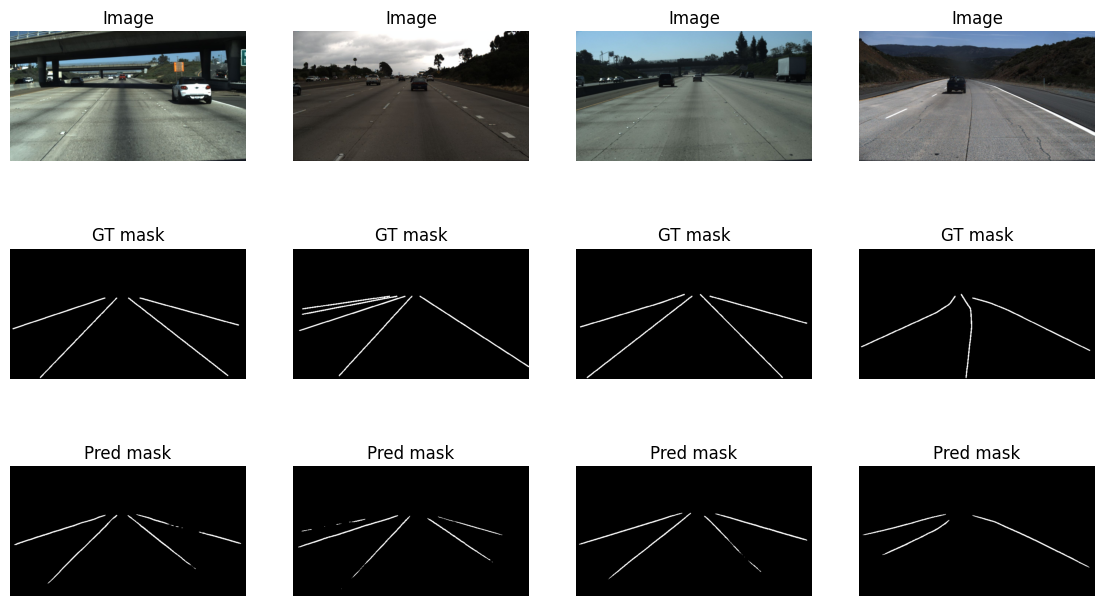

In [42]:
load_unet_ckpt(model, "unet_tiny_tusimple.pth", device=device, strict=True)
model.eval()

def visualize_batch(dataset, count=4):
    idxs = random.sample(range(len(dataset)), k=min(count, len(dataset)))
    plt.figure(figsize=(14, 8))
    for i, idx in enumerate(idxs):
        img_t, mask_t, path = dataset[idx]
        with torch.no_grad():
            logits = model(img_t.unsqueeze(0).to(device))
            prob = torch.sigmoid(logits)[0,0].cpu().numpy()

        img = (img_t.permute(1,2,0).numpy()*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        img = np.clip(img, 0, 1)
        mask = mask_t[0].numpy()
        pred = (prob > 0.5).astype(np.uint8)

        plt.subplot(3, len(idxs), i+1); plt.title("Image"); plt.imshow(img); plt.axis("off")
        plt.subplot(3, len(idxs), len(idxs)+i+1); plt.title("GT mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
        plt.subplot(3, len(idxs), 2*len(idxs)+i+1); plt.title("Pred mask"); plt.imshow(pred, cmap="gray"); plt.axis("off")
    plt.show()

visualize_batch(valid_ds, count=4)

In [43]:
def predict_video_from_clip(clip_dir, out_path="dl_lane_clip.mp4", fps=20, alpha=0.4, thresh=0.5):
    clip_dir = Path(clip_dir)
    img_paths = sorted(clip_dir.glob("*.jpg"), key=lambda p: int(p.stem))
    assert img_paths, f"이미지 없음: {clip_dir}"
    # 첫 프레임 크기
    first = cv2.imread(str(img_paths[0]))
    H, W = first.shape[:2]
    writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))
    assert writer.isOpened(), "VideoWriter 생성 실패"

    tfm = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    for p in img_paths:
        bgr = cv2.imread(str(p))
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        rgb_rs = cv2.resize(rgb, (640,352))
        inp = tfm(rgb_rs).unsqueeze(0).to(device)
        with torch.no_grad():
            logit = model(inp)
            prob  = torch.sigmoid(logit)[0,0].cpu().numpy()
        pred_small = (prob > thresh).astype(np.uint8)*255
        pred = cv2.resize(pred_small, (W, H), interpolation=cv2.INTER_NEAREST)

        # 컬러 오버레이 (녹색)
        overlay = bgr.copy()
        overlay[pred>0] = (0,255,0)
        out = cv2.addWeighted(overlay, alpha, bgr, 1-alpha, 0)
        writer.write(out)
    writer.release()
    print(f"저장 완료: {out_path}")

In [44]:
predict_video_from_clip('/home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/test_set/clips/0530/1492626760788443246_0',
                        out_path='dl_lane_0530.mp4', fps=20)

저장 완료: dl_lane_0530.mp4
